## Project 4 - Generating Mnist Handwritten Digits using GAN

### Setup

In [1]:
import numpy as np
import pandas as pd

import skimage
from skimage.io import imread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os


### Miscellaneous Function

In [27]:
def print_imgs(examples, n=10):
	# plot images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i], cmap='gray_r')
	
	plt.show()
    

In [3]:
def load_real_samples():
    (trainX,_),(_,_) = keras.datasets.mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

In [4]:
# Get a batch of dataset sample
def generate_real_samples(data, number_of_samples):
    i = np.random.randint(0,data.shape[0], number_of_samples)
    X = data[i]
    y = np.ones((number_of_samples, 1))

    return X, y

In [34]:
# Get a batch of fake samples
def generate_fake_samples_discriminator(n_samples):
	X = np.random.rand(28 * 28 * n_samples)
	X = X.reshape((n_samples, 28, 28, 1))
	y = np.zeros((n_samples, 1))
	return X, y

In [35]:
# Generate latent space points for the generator
def generate_latent_points(latent_dim, number_of_samples):
    x = np.random.randn(latent_dim * number_of_samples)
    x = x.reshape(number_of_samples, latent_dim)
    return x


In [7]:
def generate_fake_samples(g_model, latent_dim, number_of_samples):
    x_input = generate_latent_points(latent_dim, number_of_samples)
    X = g_model.predict(x_input)
    y = np.zeros((number_of_samples, 1))

    return X, y

### Getting Data and Defining Model

#### Dataset - Mnist

In [8]:
# Loading Mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [9]:
print("Train - X : " , x_train.shape," Y : ", y_train.shape)

Train - X :  (60000, 28, 28)  Y :  (60000,)


In [10]:
print("Test - X : " , x_test.shape," Y : ", y_test.shape)

Test - X :  (10000, 28, 28)  Y :  (10000,)


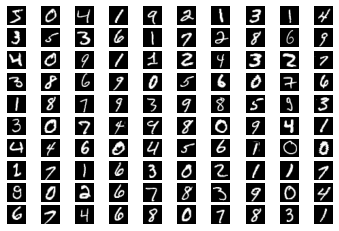

In [11]:
# Train Image view check
print_imgs(x_train)

#### Discriminator

In [12]:
def discriminator_model(input_shape=(28,28,1)):
    model = tf.keras.models.Sequential([
        # keras.Input(input_shape),
        layers.Conv2D(64, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None), input_shape=input_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(64, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

    return model

In [13]:
model = discriminator_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

#### Generator

In [15]:
def generator_model(latent_dim):
    n_nodes = 128 * 7 * 7
    model = tf.keras.models.Sequential([
        layers.Dense(n_nodes, input_dim=latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        # upsample to 14x14
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        # upsample to 28x28
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7,7), activation='sigmoid', padding='same')
    ])

    return model

In [16]:
latent_dim = 100

model = generator_model(latent_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

##### Test

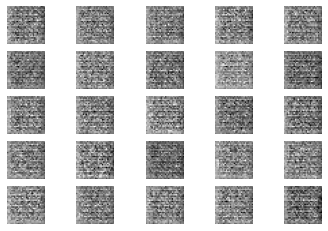

In [17]:
# size of the latent space
latent_dim = 200
# define the discriminator model
model = generator_model(latent_dim)

n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

for i in range(n_samples):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')

plt.show()

In [18]:
X.shape

(25, 28, 28, 1)

#### GAN

In [19]:
def GAN(g_model, d_model):
    d_model.trainable = False
    model = tf.keras.models.Sequential([
        g_model,
        d_model
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

    return model

In [20]:
# size of the latent space
latent_dim = 200

d_model = discriminator_model()
g_model = generator_model(latent_dim)
gan_model = GAN(g_model, d_model)

gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1791489   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,832,194
Trainable params: 1,791,489
Non-trainable params: 40,705
_________________________________________________________________


### Training

In [45]:
# Train only discriminator
def train_discriminator(model, data, number_of_iteration = 20, batch_size = 256):
    half_batch = int(batch_size/2)

    for i in range(number_of_iteration):
        X_real, y_real = generate_real_samples(data,half_batch)
        _,real_acc = model.train_on_batch(X_real,y_real)

        X_fake, y_fake = generate_fake_samples_discriminator(half_batch)
        _,fake_acc = model.train_on_batch(X_fake,y_fake)

        # print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [90]:
# Train the whole GAN model
# Dicsriminator is trained seperately before passing into GAN in each epoch
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	d_loss = 1
	for i in range(n_epochs):			
		for j in range(bat_per_epo):
			# Data for Generator training in GAN
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)
			
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
			# Condition to break if g_loss is too low, in order to avoid overfitting and also to trigger training for discriminator
			if(g_loss < 0.1 and i != n_epochs - 1):
				break

		# Training Discriminator
		# Condition to train only if g_loss is low enough
		if (g_loss > 0.4):
			continue
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# Training Discriminator
			d_loss, _ = d_model.train_on_batch(X, y)

#### Train and Evalute

In [95]:
latent_dim = 100
# Discriminator
d_model = discriminator_model()
# load real data
data = load_real_samples()
train_discriminator(d_model, data, 50, 600)

# Generator
g_model = generator_model(latent_dim)
# GAN
gan_model = GAN(g_model, d_model)

# train model
train(g_model, d_model, gan_model, data, latent_dim)

>1, 1/234, d=1.000, g=9.066
>1, 2/234, d=1.000, g=8.564
>1, 3/234, d=1.000, g=7.882
>1, 4/234, d=1.000, g=6.498
>1, 5/234, d=1.000, g=4.566
>1, 6/234, d=1.000, g=2.385
>1, 7/234, d=1.000, g=1.049
>1, 8/234, d=1.000, g=0.621
>1, 9/234, d=1.000, g=0.562
>1, 10/234, d=1.000, g=0.556
>1, 11/234, d=1.000, g=0.555
>1, 12/234, d=1.000, g=0.554
>1, 13/234, d=1.000, g=0.553
>1, 14/234, d=1.000, g=0.554
>1, 15/234, d=1.000, g=0.554
>1, 16/234, d=1.000, g=0.553
>1, 17/234, d=1.000, g=0.554
>1, 18/234, d=1.000, g=0.553
>1, 19/234, d=1.000, g=0.553
>1, 20/234, d=1.000, g=0.553
>1, 21/234, d=1.000, g=0.553
>1, 22/234, d=1.000, g=0.553
>1, 23/234, d=1.000, g=0.554
>1, 24/234, d=1.000, g=0.554
>1, 25/234, d=1.000, g=0.554
>1, 26/234, d=1.000, g=0.553
>1, 27/234, d=1.000, g=0.553
>1, 28/234, d=1.000, g=0.554
>1, 29/234, d=1.000, g=0.553
>1, 30/234, d=1.000, g=0.553
>1, 31/234, d=1.000, g=0.554
>1, 32/234, d=1.000, g=0.553
>1, 33/234, d=1.000, g=0.553
>1, 34/234, d=1.000, g=0.554
>1, 35/234, d=1.000, g=

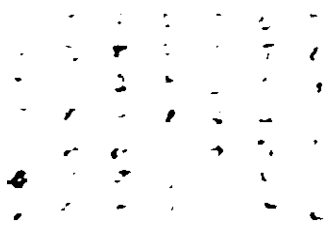

In [260]:
latent_points = generate_latent_points(100, 49)
# generate images
X = g_model.predict(latent_points)

print_imgs(X,7)

### Summary

What I have tried to achieve is to generate handwritten digit samples by using a GAN architecture and Mnist dataset as the base. After 50 epochs of training the model could generate images of 28*28 size from a latent space of 100 floating point values. It has learnt to generate major portions of digits at the center of the image and to keep the background as noiseless as possible. There were certain example that mimicked few numbers but they were not clear or precise.

Maybe a different approach to training the models could help increase the possibility of getting a clear digit. Another way of improvement I see is in the latent space, maybe a smaller latent space is better. The paper I refered to suggested to train the discriminator and GAN together which when I tried constantly increased the error of the generator not letting it train properly.

Submitting this project as it is due to time constraint. My future work would also include try different model architecture for both the generator and discriminator